In [5]:
pip install --upgrade yfinance


  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/42/88/2127d45519d1d413f564d4be9e8d12857ba42c4d76f87aec2f78e99233e4/yfinance-0.2.55-py2.py3-none-any.whl.metadata
  Using cached yfinance-0.2.55-py2.py3-none-any.whl.metadata (5.8 kB)
Using cached yfinance-0.2.55-py2.py3-none-any.whl (109 kB)
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.48
    Uninstalling yfinance-0.2.48:
      Successfully uninstalled yfinance-0.2.48
Note: you may need to restart the kernel to use updated packages.


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- PARAMETERS ---
TICKER = "AAPL"
START_DATE = "2019-03-25"
END_DATE = "2025-03-25"
ROLLING_WINDOW = 52
THRESHOLD_K = 1.5
PE_NOW = 25

In [3]:
# --- FUNCTION 1: Get Weekly Prices ---
def get_weekly_prices(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)  # auto_adjust=True is default
    data.index = pd.to_datetime(data.index)
    weekly_prices = data['Close'].resample('W-FRI').last()
    return weekly_prices.dropna()


In [4]:
weekly_prices=get_weekly_prices(TICKER, START_DATE,END_DATE)
weekly_prices.head(5)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2019-03-29,45.501312
2019-04-05,47.190094
2019-04-12,47.638039
2019-04-19,48.833374
2019-04-26,48.938763


In [5]:
# --- FUNCTION 2: Simulate P/E Time Series ---

#Index used a reference for Dates
#Pe_value to be used as reference for the Stock; value stock would have lower


def simulate_pe_series(index, pe_value, std_dev=5, seed=42):
    np.random.seed(seed)
    simulated = np.random.normal(loc=pe_value, scale=std_dev, size=len(index))
    return pd.Series(simulated, index=index)

In [6]:
index_2023 = weekly_prices[weekly_prices.index >= '2023-01-01'].index #Choose the sdtyating date you want

In [7]:
index_2023

DatetimeIndex(['2023-01-06', '2023-01-13', '2023-01-20', '2023-01-27',
               '2023-02-03', '2023-02-10', '2023-02-17', '2023-02-24',
               '2023-03-03', '2023-03-10',
               ...
               '2025-01-24', '2025-01-31', '2025-02-07', '2025-02-14',
               '2025-02-21', '2025-02-28', '2025-03-07', '2025-03-14',
               '2025-03-21', '2025-03-28'],
              dtype='datetime64[ns]', name='Date', length=117, freq='W-FRI')

In [8]:
simulated_pe_2023 = simulate_pe_series(index_2023, pe_value=25)
simulated_pe_2023.head(3)

Date
2023-01-06    27.483571
2023-01-13    24.308678
2023-01-20    28.238443
Freq: W-FRI, dtype: float64

In [9]:
simulated_pe = simulate_pe_series(weekly_prices.index, pe_value=25)


In [10]:
def generate_signals(pe_series, window, k, pe_value=25, default_std=2):
    # 1. Rolling stats
    rolling_mean = pe_series.rolling(window=window).mean()
    rolling_std = pe_series.rolling(window=window).std()

    # 2. Fill missing values with default assumptions
    rolling_mean_filled = rolling_mean.fillna(pe_value)
    rolling_std_filled = rolling_std.fillna(default_std)

    # 3. Create upper/lower bands
    upper_band = rolling_mean_filled + k * rolling_std_filled
    lower_band = rolling_mean_filled - k * rolling_std_filled

    # 4. Generate trading signals
    signals = pd.Series(0, index=pe_series.index)
    signals[pe_series < lower_band] = 1   # Long
    signals[pe_series > upper_band] = -1  # Short

    # 5. Return filled values (used for plotting) and signals
    return signals, rolling_mean_filled, upper_band, lower_band


In [45]:
signals, rolling_mean, upper_band, lower_band = generate_signals(
    simulated_pe_2023, window=25, k=0.5
)
#Need to see if we do want to clean the Nan or assume we make no move

In [46]:
signals

Date
2023-01-06   -1
2023-01-13    0
2023-01-20   -1
2023-01-27   -1
2023-02-03    1
             ..
2025-02-28    0
2025-03-07   -1
2025-03-14    0
2025-03-21    0
2025-03-28    0
Freq: W-FRI, Length: 117, dtype: int64

In [47]:
rolling_mean
#To solve the Nas (for the first 51 weeks I imposed the PE of reference 

Date
2023-01-06    25.000000
2023-01-13    25.000000
2023-01-20    25.000000
2023-01-27    25.000000
2023-02-03    25.000000
                ...    
2025-02-28    24.222433
2025-03-07    24.821033
2025-03-14    24.679908
2025-03-21    24.720802
2025-03-28    24.520130
Freq: W-FRI, Length: 117, dtype: float64

In [48]:
# --- FUNCTION 4: Backtest the Strategy ---
def backtest_strategy(prices, signals):
    returns = prices.pct_change().fillna(0)
    strategy_returns = signals.shift(1) * returns  # avoid lookahead
    cumulative_returns = (1 + strategy_returns).cumprod()
    return cumulative_returns, strategy_returns

In [49]:
weekly_prices_2023 = weekly_prices[weekly_prices.index >= '2023-01-01'] #try different period

In [50]:
returns = weekly_prices_2023.pct_change().fillna(0)

In [51]:
signals

Date
2023-01-06   -1
2023-01-13    0
2023-01-20   -1
2023-01-27   -1
2023-02-03    1
             ..
2025-02-28    0
2025-03-07   -1
2025-03-14    0
2025-03-21    0
2025-03-28    0
Freq: W-FRI, Length: 117, dtype: int64

In [52]:
# If returns is a DataFrame (common), make sure to pull the right column
if isinstance(returns, pd.DataFrame):
    returns = returns['AAPL']

In [53]:
returns

Date
2023-01-06    0.000000
2023-01-13    0.039654
2023-01-20    0.023078
2023-01-27    0.058461
2023-02-03    0.058727
                ...   
2025-02-28   -0.015109
2025-03-07   -0.011454
2025-03-14   -0.106998
2025-03-21    0.022390
2025-03-28    0.011270
Freq: W-FRI, Name: AAPL, Length: 117, dtype: float64

In [65]:
# Stretegy returns we need to shift the signals
strategy_returns = signals.shift(1) * returns 

In [66]:
#strategy_returns_abs=strategy_returns

In [67]:
cumulative_returns = (1 + strategy_returns).cumprod()
cumulative_returns

Date
2023-01-06         NaN
2023-01-13    0.960346
2023-01-20    0.960346
2023-01-27    0.904203
2023-02-03    0.851102
                ...   
2025-02-28    1.261384
2025-03-07    1.261384
2025-03-14    1.396349
2025-03-21    1.396349
2025-03-28    1.396349
Freq: W-FRI, Length: 117, dtype: float64

In [68]:
results_df = pd.DataFrame({
    "Date": index_2023,
    "Signal": signals,
    "P/E": simulated_pe_2023,
    "Upper Band": upper_band,
    "Lower band": lower_band,
    "Return": returns,
    "Strategy_Return": strategy_returns,
    "Cumulative_Return": cumulative_returns
})


In [69]:
results_df.head(10)

,Date,Signal,P/E,Upper Band,Lower band,Return,Strategy_Return,Cumulative_Return
Date,,,,,,,,
2023-01-06,2023-01-06,-1,27.483571,26.0,24.0,0.000000,NaN,NaN
2023-01-13,2023-01-13,0,24.308678,26.0,24.0,0.039654,-0.039654,0.960346
2023-01-20,2023-01-20,-1,28.238443,26.0,24.0,0.023078,0.000000,0.960346
2023-01-27,2023-01-27,-1,32.615149,26.0,24.0,0.058461,-0.058461,0.904203
2023-02-03,2023-02-03,1,23.829233,26.0,24.0,0.058727,-0.058727,0.851102
2023-02-10,2023-02-10,1,23.829315,26.0,24.0,-0.021097,-0.021097,0.833147
2023-02-17,2023-02-17,-1,32.896064,26.0,24.0,0.010198,0.010198,0.841643
2023-02-24,2023-02-24,-1,28.837174,26.0,24.0,-0.038283,0.038283,0.873863
2023-03-03,2023-03-03,1,22.652628,26.0,24.0,0.029446,-0.029446,0.848132


In [70]:
simulated_pe_2023 = simulate_pe_series(weekly_prices_2023.index, pe_value=25)


In [71]:
def plot_results(cumulative_returns, pe_series, rolling_mean, upper_band, lower_band, signals):
    # Align series
    signals = signals.loc[pe_series.index]

    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot cumulative returns
    axs[0].plot(cumulative_returns, label='Strategy Cumulative Return')
    axs[0].set_title("Value Strategy on AAPL (P/E-based)")
    axs[0].set_ylabel("Cumulative Return")
    axs[0].legend()
    axs[0].grid(True)

    # Plot P/E and signals
    axs[1].plot(pe_series, label='Simulated P/E', color='black', alpha=0.6)
    axs[1].plot(rolling_mean, label='Rolling Mean', linestyle='--')
    axs[1].plot(upper_band, label='Upper Band', linestyle=':')
    axs[1].plot(lower_band, label='Lower Band', linestyle=':')

    axs[1].scatter(signals[signals == 1].index, pe_series[signals == 1], label='Long', marker='^', color='green')
    axs[1].scatter(signals[signals == -1].index, pe_series[signals == -1], label='Short', marker='v', color='red')

    axs[1].set_title("Simulated P/E with Signal Bands")
    axs[1].set_ylabel("P/E Ratio")
    axs[1].legend()
    axs[1].grid(True)

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()


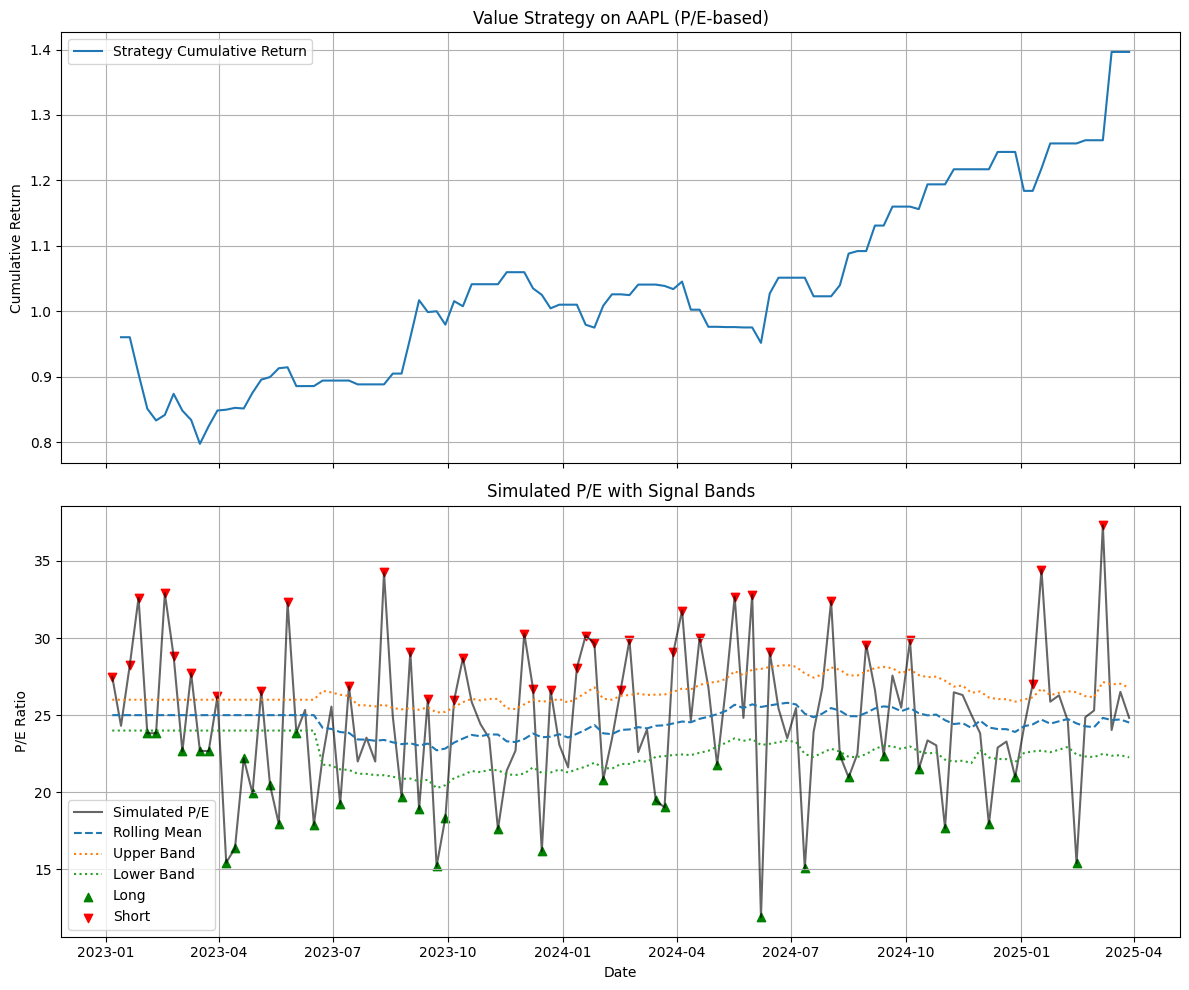

In [72]:
plot_results(cumulative_returns, simulated_pe_2023, rolling_mean, upper_band, lower_band, signals)

In [73]:
def plot_signals_on_price(prices, signals):
    plt.figure(figsize=(12, 5))
    plt.plot(prices, label='AAPL Price', linewidth=2)
    plt.scatter(signals[signals == 1].index, prices[signals == 1], label='Long', marker='^', color='green')
    plt.scatter(signals[signals == -1].index, prices[signals == -1], label='Short', marker='v', color='red')
    plt.title("AAPL Price with Trading Signals")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


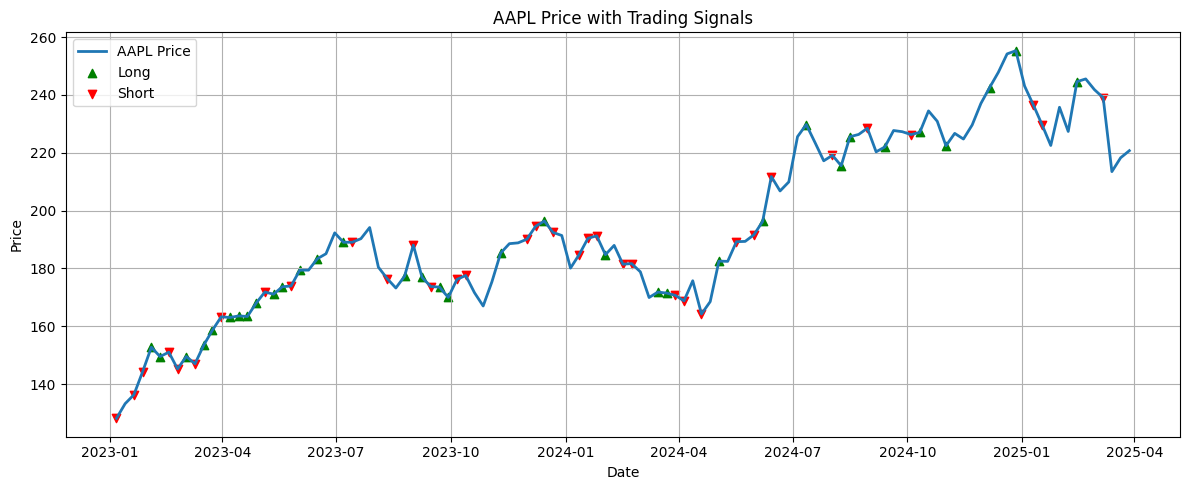

In [74]:
plot_signals_on_price(weekly_prices_2023, signals)

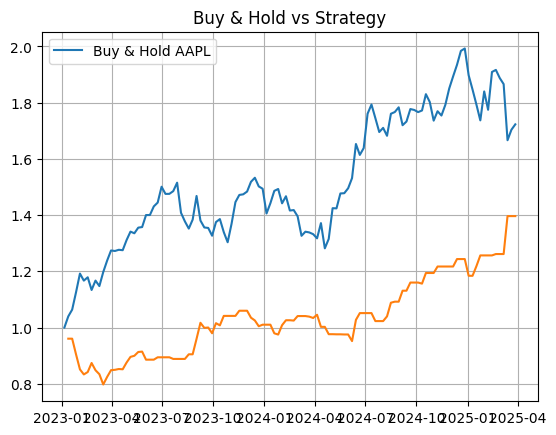

In [75]:
buy_and_hold = (1 + weekly_prices_2023.pct_change().fillna(0)).cumprod()
plt.plot(buy_and_hold, label='Buy & Hold AAPL')
plt.plot(cumulative_returns)
plt.legend()
plt.title("Buy & Hold vs Strategy")
plt.grid(True)
plt.show()
